In [1]:
#FCN8
import time
#import cv2
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
#import imutils
import matplotlib.image as mpimg
from collections import OrderedDict
import pandas as pd

from skimage import io, transform
from math import *
import xml.etree.ElementTree as ET 
import pandas as pd
from skimage.transform import AffineTransform, warp
from skimage.transform import rotate as rotate_transform
from skimage.util import random_noise
from skimage.filters import gaussian
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.models.segmentation import fcn_resnet50
from torchvision import models
from scipy.stats import multivariate_normal
torch.cuda.empty_cache()


class FCN8s_(nn.Module):

    def __init__(self, n_class):
        super().__init__()
        self.n_class = n_class
        #self.pretrained_net = pretrained_net
        self.relu    = nn.ReLU(inplace=True)
        self.deconv1 = nn.ConvTranspose2d(512, 512, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn1     = nn.BatchNorm2d(512)
        self.deconv2 = nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn2     = nn.BatchNorm2d(256)
        self.deconv3 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn3     = nn.BatchNorm2d(128)
        self.deconv4 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn4     = nn.BatchNorm2d(64)
        self.deconv5 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn5     = nn.BatchNorm2d(32)
        self.classifier = nn.Conv2d(32, n_class, kernel_size=1)

    def forward(self, x):
        #output = self.pretrained_net(x)
        x5 = output['x5']  # size=(N, 512, x.H/32, x.W/32)
        x4 = output['x4']  # size=(N, 512, x.H/16, x.W/16)
        x3 = output['x3']  # size=(N, 256, x.H/8,  x.W/8)

        score = self.relu(self.deconv1(x5))               # size=(N, 512, x.H/16, x.W/16)
        score = self.bn1(score + x4)                      # element-wise add, size=(N, 512, x.H/16, x.W/16)
        score = self.relu(self.deconv2(score))            # size=(N, 256, x.H/8, x.W/8)
        score = self.bn2(score + x3)                      # element-wise add, size=(N, 256, x.H/8, x.W/8)
        score = self.bn3(self.relu(self.deconv3(score)))  # size=(N, 128, x.H/4, x.W/4)
        score = self.bn4(self.relu(self.deconv4(score)))  # size=(N, 64, x.H/2, x.W/2)
        score = self.bn5(self.relu(self.deconv5(score)))  # size=(N, 32, x.H, x.W)
        score = self.classifier(score)                    # size=(N, n_class, x.H/1, x.W/1)

        return score  # size=(N, n_class, x.H/1, x.W/1)

class FCN8s(nn.Module):

    def __init__(self, input_channels, n_class=21):
        super(FCN8s, self).__init__()
        # conv1
        self.conv1_1 = nn.Conv2d(input_channels, 64, 3, padding=1)
        self.relu1_1 = nn.ReLU(inplace=True)
        self.conv1_2 = nn.Conv2d(64, 64, 3, padding=1)
        self.relu1_2 = nn.ReLU(inplace=True)
        self.pool1 = nn.MaxPool2d(2, stride=2, ceil_mode=True)  # 1/2

        # conv2
        self.conv2_1 = nn.Conv2d(64, 128, 3, padding=1)
        self.relu2_1 = nn.ReLU(inplace=True)
        self.conv2_2 = nn.Conv2d(128, 128, 3, padding=1)
        self.relu2_2 = nn.ReLU(inplace=True)
        self.pool2 = nn.MaxPool2d(2, stride=2, ceil_mode=True)  # 1/4

        # conv3
        self.conv3_1 = nn.Conv2d(128, 256, 3, padding=1)
        self.relu3_1 = nn.ReLU(inplace=True)
        self.conv3_2 = nn.Conv2d(256, 256, 3, padding=1)
        self.relu3_2 = nn.ReLU(inplace=True)
        self.conv3_3 = nn.Conv2d(256, 256, 3, padding=1)
        self.relu3_3 = nn.ReLU(inplace=True)
        self.pool3 = nn.MaxPool2d(2, stride=2, ceil_mode=True)  # 1/8

        # conv4
        self.conv4_1 = nn.Conv2d(256, 512, 3, padding=1)
        self.relu4_1 = nn.ReLU(inplace=True)
        self.conv4_2 = nn.Conv2d(512, 512, 3, padding=1)
        self.relu4_2 = nn.ReLU(inplace=True)
        self.conv4_3 = nn.Conv2d(512, 512, 3, padding=1)
        self.relu4_3 = nn.ReLU(inplace=True)
        self.pool4 = nn.MaxPool2d(2, stride=2, ceil_mode=True)  # 1/16

        # conv5
        self.conv5_1 = nn.Conv2d(512, 512, 3, padding=1)
        self.relu5_1 = nn.ReLU(inplace=True)
        self.conv5_2 = nn.Conv2d(512, 512, 3, padding=1)
        self.relu5_2 = nn.ReLU(inplace=True)
        self.conv5_3 = nn.Conv2d(512, 512, 3, padding=1)
        self.relu5_3 = nn.ReLU(inplace=True)
        self.pool5 = nn.MaxPool2d(2, stride=2, ceil_mode=True)  # 1/32

        # fc6
        self.fc6 = nn.Conv2d(512, 4096, 7)
        self.relu6 = nn.ReLU(inplace=True)
        self.drop6 = nn.Dropout2d()

        # fc7
        self.fc7 = nn.Conv2d(4096, 4096, 1)
        self.relu7 = nn.ReLU(inplace=True)
        self.drop7 = nn.Dropout2d()

        self.score_fr = nn.Conv2d(4096, n_class, 1)
        self.score_pool3 = nn.Conv2d(256, n_class, 1)
        self.score_pool4 = nn.Conv2d(512, n_class, 1)

        self.upscore2 = nn.ConvTranspose2d(
            n_class, n_class, 4, stride=2, bias=False)
        self.upscore8 = nn.ConvTranspose2d(
            n_class, n_class, 16, stride=8, bias=False)
        self.upscore_pool4 = nn.ConvTranspose2d(
            n_class, n_class, 4, stride=2, bias=False)



    def forward(self, x):
        h = x
        h = self.relu1_1(self.conv1_1(h))
        h = self.relu1_2(self.conv1_2(h))
        h = self.pool1(h)

        h = self.relu2_1(self.conv2_1(h))
        h = self.relu2_2(self.conv2_2(h))
        h = self.pool2(h)

        h = self.relu3_1(self.conv3_1(h))
        h = self.relu3_2(self.conv3_2(h))
        h = self.relu3_3(self.conv3_3(h))
        h = self.pool3(h)
        pool3 = h  # 1/8

        h = self.relu4_1(self.conv4_1(h))
        h = self.relu4_2(self.conv4_2(h))
        h = self.relu4_3(self.conv4_3(h))
        h = self.pool4(h)
        pool4 = h  # 1/16

        h = self.relu5_1(self.conv5_1(h))
        h = self.relu5_2(self.conv5_2(h))
        h = self.relu5_3(self.conv5_3(h))
        h = self.pool5(h)

        h = self.relu6(self.fc6(h))
        h = self.drop6(h)

        h = self.relu7(self.fc7(h))
        h = self.drop7(h)

        h = self.score_fr(h)
        h = self.upscore2(h)
        upscore2 = h  # 1/16

        h = self.score_pool4(pool4)
        h = h[:, :, 5:5 + upscore2.size()[2], 5:5 + upscore2.size()[3]]
        score_pool4c = h  # 1/16

        h = upscore2 + score_pool4c  # 1/16
        h = self.upscore_pool4(h)
        upscore_pool4 = h  # 1/8

        h = self.score_pool3(pool3)
        h = h[:, :,
              9:9 + upscore_pool4.size()[2],
              9:9 + upscore_pool4.size()[3]]
        score_pool3c = h  # 1/8

        h = upscore_pool4 + score_pool3c  # 1/8

        h = self.upscore8(h)
        h = h[:, :, 31:31 + x.size()[2], 31:31 + x.size()[3]].contiguous()

        return h
        
class resnet50_FCN8(nn.Module):
    def __init__(self,num_classes=11):
        super().__init__()
        self.model_name='resnet50'
        self.model=models.resnet50(pretrained=True)
        self.model.conv1=nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.model.fc=FCN8s(self.model.fc.in_features, num_classes)#nn.Linear(self.model.fc.in_features, num_classes)
        
    def forward(self, x):
        x=self.model(x)
        return x


class fcn_resnet50(nn.Module):
    def __init__(self,num_classes=11):
        super().__init__()
        self.model_name='fcn_resnet50'
        self.model=models.segmentation.fcn_resnet50(pretrained=False)
        self.model.classifier=FCN8s(2048, num_classes)
        
    def forward(self, x):
        x=self.model(x)
        return x

class fcn_resnet50_(nn.Module):
    def __init__(self,num_classes=22):
        super().__init__()
        self.model_name='fcn_resnet50'
        self.model=models.segmentation.fcn_resnet50(pretrained=False)
        self.model.classifier[4]=nn.Conv2d(512, 11, kernel_size=(1,1), stride=(1,1))
        
    def forward(self, x):
        x=self.model(x)['out']
        return x

import torch
import torch.nn as nn
from torchvision import models

def convrelu(in_channels, out_channels, kernel, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
        nn.ReLU(inplace=True),
    )


class ResNetUNet(nn.Module):
    def __init__(self, n_class):
        super().__init__()

        self.base_model = models.resnet34(pretrained=True)
        self.base_layers = list(self.base_model.children())

        self.layer0 = nn.Sequential(*self.base_layers[:3]) # size=(N, 64, x.H/2, x.W/2)
        self.layer0_1x1 = convrelu(64, 64, 1, 0)
        self.layer1 = nn.Sequential(*self.base_layers[3:5]) # size=(N, 64, x.H/4, x.W/4)
        self.layer1_1x1 = convrelu(64, 64, 1, 0)
        self.layer2 = self.base_layers[5]  # size=(N, 128, x.H/8, x.W/8)
        self.layer2_1x1 = convrelu(128, 128, 1, 0)
        self.layer3 = self.base_layers[6]  # size=(N, 256, x.H/16, x.W/16)
        self.layer3_1x1 = convrelu(256, 256, 1, 0)
        self.layer4 = self.base_layers[7]  # size=(N, 512, x.H/32, x.W/32)
        self.layer4_1x1 = convrelu(512, 512, 1, 0)

        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv_up3 = convrelu(256 + 512, 512, 3, 1)
        self.conv_up2 = convrelu(128 + 512, 256, 3, 1)
        self.conv_up1 = convrelu(64 + 256, 256, 3, 1)
        self.conv_up0 = convrelu(64 + 256, 128, 3, 1)

        self.conv_original_size0 = convrelu(3, 64, 3, 1)
        self.conv_original_size1 = convrelu(64, 64, 3, 1)
        self.conv_original_size2 = convrelu(64 + 128, 64, 3, 1)

        self.conv_last = nn.Conv2d(64, n_class, 1)

    def forward(self, input):
        x_original = self.conv_original_size0(input)
        x_original = self.conv_original_size1(x_original)

        layer0 = self.layer0(input)
        layer1 = self.layer1(layer0)
        layer2 = self.layer2(layer1)
        layer3 = self.layer3(layer2)
        layer4 = self.layer4(layer3)

        layer4 = self.layer4_1x1(layer4)
        x = self.upsample(layer4)
        layer3 = self.layer3_1x1(layer3)
        x = torch.cat([x, layer3], dim=1)
        x = self.conv_up3(x)

        x = self.upsample(x)
        layer2 = self.layer2_1x1(layer2)
        x = torch.cat([x, layer2], dim=1)
        x = self.conv_up2(x)

        x = self.upsample(x)
        layer1 = self.layer1_1x1(layer1)
        x = torch.cat([x, layer1], dim=1)
        x = self.conv_up1(x)

        x = self.upsample(x)
        layer0 = self.layer0_1x1(layer0)
        x = torch.cat([x, layer0], dim=1)
        x = self.conv_up0(x)

        x = self.upsample(x)
        x = torch.cat([x, x_original], dim=1)
        x = self.conv_original_size2(x)

        out = self.conv_last(x)

        return out

In [2]:
print(fcn_resnet50_().model.classifier)
print(fcn_resnet50().model.classifier)


FCNHead(
  (0): Conv2d(2048, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Dropout(p=0.1, inplace=False)
  (4): Conv2d(512, 11, kernel_size=(1, 1), stride=(1, 1))
)
FCN8s(
  (conv1_1): Conv2d(2048, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1_1): ReLU(inplace=True)
  (conv1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1_2): ReLU(inplace=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2_1): ReLU(inplace=True)
  (conv2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2_2): ReLU(inplace=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv3_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1

In [77]:
model = FCN8s(3,11)
x    = torch.randn(1, 3, 224, 224)
output = model(x)

In [14]:
model = ResNetUNet(11)
x    = torch.randn(1, 3, 320, 320)
output = model(x)
output

tensor([[[[ 0.0708,  0.0510,  0.0435,  ...,  0.0449,  0.0602,  0.0523],
          [ 0.0588,  0.0584,  0.0301,  ...,  0.0332,  0.0360,  0.0363],
          [ 0.0618,  0.0597,  0.0547,  ...,  0.0611,  0.0505,  0.0387],
          ...,
          [ 0.0522,  0.0471,  0.0630,  ...,  0.0649,  0.0274,  0.0413],
          [ 0.0744,  0.0563,  0.0373,  ...,  0.0540,  0.0347,  0.0396],
          [ 0.0650,  0.0477,  0.0485,  ...,  0.0425,  0.0331,  0.0509]],

         [[ 0.0474,  0.0604,  0.0510,  ...,  0.0686,  0.0545,  0.0489],
          [ 0.0440,  0.0388,  0.0534,  ...,  0.0683,  0.0618,  0.0461],
          [ 0.0478,  0.0155,  0.0252,  ...,  0.0504,  0.0560,  0.0396],
          ...,
          [ 0.0345,  0.0480,  0.0550,  ...,  0.0420,  0.0444,  0.0414],
          [ 0.0403,  0.0459,  0.0330,  ...,  0.0357,  0.0517,  0.0298],
          [ 0.0347,  0.0343,  0.0200,  ...,  0.0147,  0.0435,  0.0342]],

         [[-0.0985, -0.0967, -0.1077,  ..., -0.1021, -0.0886, -0.0925],
          [-0.1098, -0.1141, -

In [5]:
output.size()

torch.Size([1, 11, 224, 224])

In [2]:




import time
#import cv2
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
#import imutils
import matplotlib.image as mpimg
from collections import OrderedDict
import pandas as pd

from skimage import io, transform
from math import *
import xml.etree.ElementTree as ET 
import pandas as pd
from skimage.transform import AffineTransform, warp
from skimage.transform import rotate as rotate_transform
from skimage.util import random_noise
from skimage.filters import gaussian
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
torch.cuda.empty_cache()



#https://github.com/princeton-vl/pytorch_stacked_hourglass/blob/master/data/MPII/dp.py
#import cv2
import sys
import os
import torch
import numpy as np
import torch.utils.data
#import utils.img

class GenerateHeatmap():
    def __init__(self, output_res, num_parts):
        self.output_res = output_res
        self.num_parts = num_parts
        sigma = self.output_res/64
        self.sigma = sigma
        size = 6*sigma + 3
        x = np.arange(0, size, 1, float)
        y = x[:, np.newaxis]
        x0, y0 = 3*sigma + 1, 3*sigma + 1
        self.g = np.exp(- ((x - x0) ** 2 + (y - y0) ** 2) / (2 * sigma ** 2))

    def __call__(self, keypoints):
        hms = np.zeros(shape = (self.num_parts, self.output_res, self.output_res), dtype = np.float32)
        sigma = self.sigma
        for p in keypoints:
            for idx, pt in enumerate(p):
                #print(pt)
                if pt[0] > 0: 
                    x, y = int(pt[0]), int(pt[1])
                    if x<0 or y<0 or x>=self.output_res or y>=self.output_res:
                        continue
                    ul = int(x - 3*sigma - 1), int(y - 3*sigma - 1)
                    br = int(x + 3*sigma + 2), int(y + 3*sigma + 2)

                    c,d = max(0, -ul[0]), min(br[0], self.output_res) - ul[0]
                    a,b = max(0, -ul[1]), min(br[1], self.output_res) - ul[1]

                    cc,dd = max(0, ul[0]), min(br[0], self.output_res)
                    aa,bb = max(0, ul[1]), min(br[1], self.output_res)
                    hms[idx, aa:bb,cc:dd] = np.maximum(hms[idx, aa:bb,cc:dd], self.g[a:b,c:d])
        return hms

def create_heatmap(output_size, landmarks):
    hms = np.zeros(shape = (11, 320, 320), dtype = np.float32)
    for i in range(11):
        landmark = landmarks[i]
        pos = np.dstack(np.mgrid[0:320:1, 0:320:1])
        rv = multivariate_normal(mean=[landmark[1].item(), landmark[0].item()], cov=12)
        hms[i,:,:] = rv.pdf(pos)
    hms = TF.to_tensor(hms)
    return hms

class Transforms():
    def __init__(self):
        pass
    
    def rotate(self, image, landmarks, params):

        angle = params['rotation_range'][0]
        angle = (random.uniform(0,1))*random.choice([-1,1])*angle
        transformation_matrix = torch.tensor([
            [+cos(radians(angle)), -sin(radians(angle))], 
            [+sin(radians(angle)), +cos(radians(angle))]
        ])

        image = rotate_transform(np.array(image), angle = angle, mode = 'edge')

        landmarks = landmarks - 0.5
        new_landmarks = np.matmul(landmarks, transformation_matrix)
        new_landmarks = new_landmarks + 0.5

        # PIL expects RGB images to be uint with ranges from 0 to 255 so we have to convert it to a type that PIL can excpect ie a uint from 0 to 255 
        return Image.fromarray((image * 255).astype(np.uint8)), new_landmarks

    def translation(self, image, landmarks, params):
        image_shape = np.array(image).shape
        ty = random.uniform(params['height_shift_range'][0]*image_shape[0],          
                            params['height_shift_range'][1]*image_shape[0])
        tx = random.uniform(params['width_shift_range'][0]*image_shape[1],
                            params['width_shift_range'][1]*image_shape[1] )

        
        horizontal_shift =  tx*random.choice([-1,1])
        vertical_shift = ty*random.choice([-1,1])
        horizontal_shift_normalised = horizontal_shift/image_shape[1]
        vertical_shift_normalised =  vertical_shift/image_shape[0]

        transform = AffineTransform(translation=(-horizontal_shift,-vertical_shift))

        image = warp(np.array(image),transform,mode='edge')

        landmarks = landmarks + torch.tensor([horizontal_shift_normalised,vertical_shift_normalised])
  
        # PIL expects RGB images to be uint with ranges from 0 to 255 so we have to convert it to a type that PIL can excpect ie a uint from 0 to 255 
        return Image.fromarray((image * 255).astype(np.uint8)), landmarks
        
    def resize(self, image, landmarks, img_size):
        image = TF.resize(image, img_size)
        return image, landmarks

    def zoom(self, image, landmarks, params):

        landmarks = landmarks.astype(int)
        img_shape = np.array(image).shape
        zoom = random.uniform(params['zoom_range'][0],params['zoom_range'][1])
        image = TF.resize(image,(int(img_shape[0]*zoom), int(img_shape[1]*zoom)) )
        scale_transform = torch.tensor([[zoom, 0], 
                                        [0, zoom]])
        landmarks = np.matmul(landmarks, scale_transform).float()
        new_img_shape = np.array(image).shape
        landmarks = landmarks / torch.tensor([new_img_shape[1], new_img_shape[0]])
        
        return image, landmarks

    def color_jitter(self, image, landmarks):
        color_jitter = transforms.ColorJitter(brightness=0.3, 
                                              contrast=0.3,
                                              saturation=0.3, 
                                              hue=0.1)
        image = color_jitter(image)
        return image, landmarks
    


    def __call__(self, image, landmarks, params):

        # set checked image and landmark to landmark_ and image_ (this is for making sure we use the last checked tranformed instead of wrongly tranformed to do the following               # tranform)
        
        # -----------------------
        image_ = Image.fromarray(image.copy())
        landmarks_ = landmarks.copy()
        # -----------------------

        # ZOOM
        image , landmarks = self.zoom(image_, landmarks_, params)
        
        image_shape = np.array(image).shape
        landmarks_bool = landmarks < 0
        # correct this becuase hight and with is different sizes # NOTE fix
        landmarks_outofbounds = landmarks*image_shape[1]  > image_shape[1]  
        while landmarks_bool.any() or landmarks_outofbounds.any():
            image, landmarks = self.zoom(image_, landmarks_, params)
            landmarks_bool = landmarks < 0
            landmarks_outofbounds = landmarks*image_shape[1]  > image_shape[1] 

        # ----------------------
        image_ = image
        landmarks_ = landmarks
        # ----------------------

        # RESIZE
        image, landmarks = self.resize(image_, landmarks_, (320, 320))
        
        image_shape = np.array(image).shape
        landmarks_bool = landmarks < 0
        landmarks_outofbounds = landmarks*image_shape[1] > image_shape[1] 
        while landmarks_bool.any() or landmarks_outofbounds.any():
            image, landmarks = self.resize(image_, landmarks_, (320, 320))
            image_shape = np.array(image).shape
            landmarks_bool = landmarks < 0
            landmarks_outofbounds = landmarks*image_shape[1]  > image_shape[1] 
        landmarks_ = landmarks
        image_ = image

        # ----------------------
        #image_, landmarks_ = self.color_jitter(image_, landmarks_)
        # ----------------------
        
        # ROTATE
        image, landmarks = self.rotate(image_, landmarks_, params)
        
        image_shape = np.array(image).shape
        landmarks_bool = landmarks < 0
        landmarks_outofbounds = landmarks*image_shape[1] > image_shape[1] 
        while landmarks_bool.any() or landmarks_outofbounds.any():
            image, landmarks = self.rotate(image_, landmarks_, params)
            image_shape = np.array(image).shape
            landmarks_bool = landmarks < 0
            landmarks_outofbounds = landmarks*image_shape[1] > image_shape[1] 


        # ----------------------
        landmarks_ = landmarks
        image_ = image
        # ----------------------

        # TRANSLATION
        image, landmarks = self.translation(image, landmarks, params)

        image_shape = np.array(image).shape
        landmarks_bool = landmarks < 0
        landmarks_outofbounds = landmarks*image_shape[1] > image_shape[1] 
        while landmarks_bool.any() or landmarks_outofbounds.any():
            image, landmarks = self.translation(image_, landmarks_, params)
            image_shape = np.array(image).shape
            landmarks_bool = landmarks < 0
            landmarks_outofbounds = landmarks*image_shape[1] > image_shape[1] 


        # ----------------------
        landmarks_ = landmarks
        image_ = image
        # ----------------------
 
        
        image = TF.to_tensor(image)
        # the following tranform normalises each channel to have a mean at 0.5 and std of 0.5 / NOTE: NOT sure if this is theoreticlly better, should check this
        image = TF.normalize(image, [0.5], [0.5])
        return image, landmarks


class LandmarksDataset():

    def __init__(self, transform=None,zoom = [1.0 - 0.03258157476873315, 1.0 + 0.03258157476873315], rotation = [22], height_shift= [0,0.03003200603616672], width_shift= [0,0.03003200603616672 ]):

        df = pd.read_csv('C:/Projects\msc_haar/tsetsedata_2019_left_commas/annotations_left.txt',index_col=0, header=None)

        df2 =  pd.read_csv('C:/Projects/msc_haar/flipped_left.csv', index_col= 0)
        self. tranform = transform
        self.zoom = zoom
        self.rotation = rotation
        self.height_shift = height_shift
        self.width_shift = width_shift
        self.image_filenames = []
        self.landmarks = []
        self.transform = transform
        self.image_dir = 'C:/Projects/msc_haar/tsetsedata_2019_left_commas/images_left/'
        self.image_dir2 = 'C:/Projects/msc_haar/tsetsedata_2019_right_commas/flipped_left/'
        self.TransF_ = True

       # ------------------- Append left wings data to dataset class ------------

        for filename in df.index[:]:
            self.image_filenames.append(os.path.join(self.image_dir, filename))
            

            landmarks = []
            for num in range(1, 23, 2):
                
                x_coordinate = df.loc[filename,num] - 1
                y_coordinate = df.loc[filename, num+1] - 1
                landmarks.append([x_coordinate, y_coordinate])
            self.landmarks.append(landmarks)
        

        assert len(self.image_filenames) == len(self.landmarks)

        # ------------------ Append flipped right wings data to dataset class-----


        for filename in df2.index[:]:

            self.image_filenames.append(os.path.join(self.image_dir2, filename))

            landmarks = []
            for num in range(1, 23, 2):
                x_coordinate = df2.loc[filename,'{}'.format(num)] +1
                y_coordinate = df2.loc[filename, '{}'.format(num+1)] +1
                landmarks.append([x_coordinate, y_coordinate])
            self.landmarks.append(landmarks)
        self.landmarks = np.array(self.landmarks).astype('float32')

        assert len(self.image_filenames) == len(self.landmarks)

        # ----------------------

    def TransF(self):
        self.TransF_ = True
    def NoTransF(self):
        self.TransF_ = False
    def set_params(self, zoom = [0.95, 0.105], rotation = [10], height_shift= [0,0.05], width_shift= [0,0.05]):
        self.zoom = zoom
        self.rotation = rotation
        self.height_shift = height_shift
        self.width_shift = width_shift
    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, index):
        params = {'zoom_range': self.zoom, 'rotation_range':self.rotation, 'height_shift_range': self.height_shift, 'width_shift_range': self.width_shift }
        image_ = plt.imread(self.image_filenames[index])
    
        landmarks_ = self.landmarks[index]
        image = plt.imread(self.image_filenames[index])
    
        landmarks = self.landmarks[index]
        
        if self.transform and self.TransF_:
            
            image, landmarks = self.transform(image_, landmarks_, params)
            image_shape = image.shape
            landmarks_bool = landmarks < 0
            landmarks_outofbounds = landmarks*320 > image_shape[1] 
            while landmarks_bool.any() or landmarks_outofbounds.any():
                image, landmarks = self.transform(image_, landmarks_, params)
                landmarks_bool = landmarks < 0
                landmarks_outofbounds = landmarks*320 > image_shape[1] 
        else:
            img_shape = image.copy().shape
            image = Image.fromarray(image)
            image = TF.resize(image, (320, 320))
            landmarks = torch.tensor(landmarks) / torch.tensor([img_shape[1],img_shape[0]])
            image = TF.to_tensor(image)
            # the following tranform normalises each channel to have a mean at 0.5 and std of 0.5 / NOTE: NOT sure if this is theoreticlly better, should check this
            image = TF.normalize(image, [0.5], [0.5])

        #hm = GenerateHeatmap(224,11)
        #hm = hm()

        landmarks = torch.tensor(landmarks) - 0.5
        landmarks = (landmarks + 0.5) * torch.tensor([320, 320])
        hms = create_heatmap(320, landmarks )
        #hms = hms.permute(1, 2, 0)#.unsqueeze(0)
        hms = hms.permute(1, 2, 0)
        #t = torch.tensor([hms[0].max() ,hms[1].max(), hms[2].max(), hms[3].max(), hms[4].max(), hms[5].max(), hms[6].max(), hms[7].max(), hms[8].max(), hms[9].max(), hms[10].max()]) 
        hms[0] = hms[0]/hms[0].max()
        hms[1] = hms[1]/hms[1].max()
        hms[2] = hms[2]/hms[2].max()
        hms[3] = hms[3]/hms[3].max()
        hms[4] = hms[4]/hms[4].max()
        hms[5] = hms[5]/hms[5].max()
        hms[6] = hms[6]/hms[6].max()
        hms[7] = hms[7]/hms[7].max()
        hms[8] = hms[8]/hms[8].max()
        hms[9] = hms[9]/hms[9].max()
        hms[10] = hms[10]/hms[10].max()
        #hms = TF.normalize(hms, [0.5], [0.5])
        #hm = GenerateHeatmap(224,11)
        #hm = TF.to_tensor(hm(landmarks.unsqueeze_(0))).permute(1, 2, 0)#.unsqueeze(0)
        #hms = create_heatmap(224, landmarks )
        #hms = hm.permute(1, 2, 0)#.unsqueeze(0)
        return image, hms


DataSet = LandmarksDataset(Transforms())



class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor

'''
You instantiate it with the same arguments used for the normalize. and then use it the same way

unorm = UnNormalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
unorm(tensor)

'''



'\nYou instantiate it with the same arguments used for the normalize. and then use it the same way\n\nunorm = UnNormalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))\nunorm(tensor)\n\n'

In [3]:
# -*- coding: utf-8 -*-
# @Time    : 2019/9/9 
# @Author  : Elliott Zheng  
# @Email   : admin@hypercube.top


import torch
from torch import nn


# torch.log  and math.log is e based
class AdaptiveWingLoss(nn.Module):
    def __init__(self, omega=14, theta=0.5, epsilon=1, alpha=2.1):
        super(AdaptiveWingLoss, self).__init__()
        self.omega = omega
        self.theta = theta
        self.epsilon = epsilon
        self.alpha = alpha

    def forward(self, pred, target):
        '''
        :param pred: BxNxHxH
        :param target: BxNxHxH
        :return:
        '''

        y = target
        y_hat = pred
        delta_y = (y - y_hat).abs()
        delta_y1 = delta_y[delta_y < self.theta]
        delta_y2 = delta_y[delta_y >= self.theta]
        y1 = y[delta_y < self.theta]
        y2 = y[delta_y >= self.theta]
        loss1 = self.omega * torch.log(1 + torch.pow(delta_y1 / self.omega, self.alpha - y1))
        A = self.omega * (1 / (1 + torch.pow(self.theta / self.epsilon, self.alpha - y2))) * (self.alpha - y2) * (
            torch.pow(self.theta / self.epsilon, self.alpha - y2 - 1)) * (1 / self.epsilon)
        C = self.theta * A - self.omega * torch.log(1 + torch.pow(self.theta / self.epsilon, self.alpha - y2))
        loss2 = A * delta_y2 - C
        return (loss1.sum() + loss2.sum()) / (len(loss1) + len(loss2))




In [4]:
# check outputs
import cv2
image_, hm = DataSet[1]
print(hm.size())
print(landmarks.size())
unorm = UnNormalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
image = unorm(image_)
image = image.permute(1, 2, 0).numpy()
landmarks = (landmarks + 0.5) * torch.tensor([224, 224])
plt.imshow(image)
#plt.scatter(landmarks[9][0], landmarks[9][1], s=3)
plt.show()

plt.imshow(hm[9])
#plt.scatter(landmarks[9][0], landmarks[9][1], s=3)
plt.show()


model = ResNetUNet(11)
image = image_.unsqueeze(0)
pred = model(image)
pred_ = pred[0][9]
print(pred.shape)
print(hm.shape)
print(pred_.size())
plt.imshow(pred_.detach().numpy())
#plt.scatter(landmarks[9][0], landmarks[9][1], s=3)
plt.show()
(minVal, maxVal, minLoc, maxLoc) = cv2.minMaxLoc(hm[7].numpy())

(minVal_, maxVal_, minLoc_, maxLoc_) = cv2.minMaxLoc(pred_.detach().numpy())
print('pred  coord ', maxLoc_)
print('true coord', maxLoc)


criterion = AdaptiveWingLoss()
print('pred_size', pred.size())
print('target_size', hm.size())
loss_0 = criterion(pred, pred) # this should be 0
loss_not0 = criterion(pred, hm.unsqueeze(0))
print('loss = 0', loss_0)
print('loss != 0', loss_not0)


<ipython-input-2-09fae7924106>:343: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  landmarks = torch.tensor(landmarks) - 0.5
torch.Size([11, 320, 320])


NameError: name 'landmarks' is not defined

In [5]:
# check outputs
import cv2
image_, hms, hm = DataSet[1]
print(hm.size())
print(landmarks.size())
unorm = UnNormalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
image = unorm(image_)
image = image.permute(1, 2, 0).numpy()
landmarks = (landmarks + 0.5) * torch.tensor([224, 224])
plt.imshow(image)
#plt.scatter(landmarks[9][0], landmarks[9][1], s=3)
plt.show()

plt.imshow(hm[9])
#plt.scatter(landmarks[9][0], landmarks[9][1], s=3)
plt.show()


model = ResNetUNet(11)
image = image_.unsqueeze(0)
pred = model(image)
pred_ = pred[0][9]
print(pred.shape)
print(hm.shape)
print(pred_.size())
plt.imshow(pred_.detach().numpy())
#plt.scatter(landmarks[9][0], landmarks[9][1], s=3)
plt.show()
(minVal, maxVal, minLoc, maxLoc) = cv2.minMaxLoc(hm[7].numpy())

(minVal_, maxVal_, minLoc_, maxLoc_) = cv2.minMaxLoc(pred_.detach().numpy())
print('pred  coord ', maxLoc_)
print('true coord', maxLoc)


criterion = AdaptiveWingLoss()
print('pred_size', pred.size())
print('target_size', hm.size())
loss_0 = criterion(pred, pred) # this should be 0
loss_not0 = criterion(pred, hm.unsqueeze(0))
print('loss = 0', loss_0)
print('loss != 0', loss_not0)
print(pred.size())
print(hm.size())
print(hm)

torch.Size([11, 224, 224])
<ipython-input-2-1a2a582ca73d>:343: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  landmarks = torch.tensor(landmarks) - 0.5


NameError: name 'landmarks' is not defined

In [ ]:
model = ResNetUNet(11)

<ipython-input-2-09fae7924106>:343: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  landmarks = torch.tensor(landmarks) - 0.5
torch.Size([3, 320, 320])


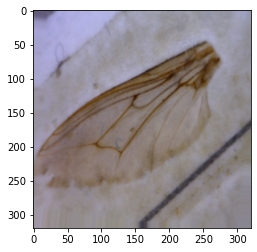

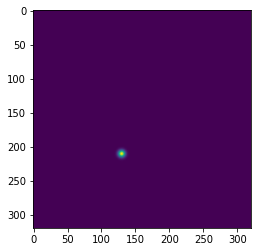

torch.Size([320, 320])


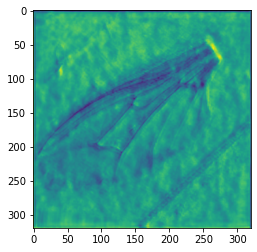

pred  coord  (0, 318)
true coord (130, 210)
pred_size torch.Size([1, 11, 320, 320])
target_size torch.Size([11, 320, 320])
loss = 0 tensor(0., grad_fn=<DivBackward0>)
loss != 0 tensor(0.0041, grad_fn=<DivBackward0>)


In [5]:
# check outputs
import cv2
image_, hm= DataSet[1]
print(image_.size())
unorm = UnNormalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
image = unorm(image_)
image = image.permute(1, 2, 0).numpy()
plt.imshow(image)
plt.show()

plt.imshow(hm[7])
plt.show()


model = ResNetUNet(11)
image = image_.unsqueeze(0)
pred = model(image)
pred_ = pred[0][7]
print(pred_.size())
plt.imshow(pred_.detach().numpy())
plt.show()
(minVal, maxVal, minLoc, maxLoc) = cv2.minMaxLoc(hm[7].numpy())

(minVal_, maxVal_, minLoc_, maxLoc_) = cv2.minMaxLoc(pred_.detach().numpy())
print('pred  coord ', maxLoc_)
print('true coord', maxLoc)


criterion = AdaptiveWingLoss()
print('pred_size', pred.size())
print('target_size', hm.size())
loss_0 = criterion(pred, pred) # this should be 0
loss_not0 = criterion(pred, hm.unsqueeze(0))
print('loss = 0', loss_0)
print('loss != 0', loss_not0)

In [6]:
DataSet.TransF()
#DataSet.resize(244)
dataset = DataSet
# split the dataset into validation and test sets
len_valid_test_set = int(0.2*len(dataset)) # 60% training, 20% validation, 20% testing

len_train_set = len(dataset) - len_valid_test_set*2

print("The length of Train set is {}".format(len_train_set))
print("The length of Valid set is {}".format(len_valid_test_set))
print("The length of Valid set is {}".format(len_valid_test_set))

train_dataset , valid_dataset, test_dataset  = torch.utils.data.random_split(dataset , [len_train_set, len_valid_test_set, len_valid_test_set], generator=torch.Generator().manual_seed(42))

# shuffle and batch the datasets
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=4, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=10, shuffle=True)



The length of Train set is 1452
The length of Valid set is 484
The length of Valid set is 484


In [7]:
# helper functions
import sys
import pickle

def print_overwrite(step, total_step, loss, operation):
    sys.stdout.write('\r')
    if operation == 'train':
        sys.stdout.write("Train Steps: %d/%d  Loss: %.10f " % (step, total_step, loss))   
    else:
        sys.stdout.write("Valid Steps: %d/%d  Loss: %.10f " % (step, total_step, loss))
        
    sys.stdout.flush()

In [8]:
import math

network = ResNetUNet(11)
#network.load_state_dict(torch.load('C:/Projects/msc_haar/manuscript1_exp/regressors/models/model_resnet50_UNET_finetune_0_s0.pth'))
network.cuda()

torch.autograd.set_detect_anomaly(True)


loss_list = {'train': [], 'val':[], 'time': [], 'procrustus_disparity': [], 'procrustus_disparity_VAL':[], 'MSE': [] , 'MSE_VAL':[]}   

criterion = AdaptiveWingLoss()
optimizer = optim.Adam(network.parameters(), lr=0.0001)

loss_min = np.inf
num_epochs = 50

start_time = time.time()
for epoch in range(1,num_epochs+1):
    loss_train = 0
    loss_valid = 0
    running_loss = 0
    
    network.train()
    for step in range(1,len(train_loader)+1):

        images, hms = next(iter(train_loader))
        
        images = images.cuda()
        hms = hms.cuda() 
      
        predictions = network(images)

        optimizer.zero_grad()
      
        #print(predictions.size())
        #print(hms.size())
        loss_train_step = criterion(predictions, hms)
        #print('loss_train_step',loss_train_step)
        
        # calculate the gradients
 
        loss_train_step.backward()
    
        
        # update the parameters
  
        optimizer.step()
    
        #loss_train += loss_train_step.item()
        #print('loss_train',loss_train)
        #print('step',step)
        #running_loss = loss_train/step
        #print('running_loss',running_loss)
        
        print_overwrite(step, len(train_loader), loss_train_step.item(), 'train')
        
    #network.eval() 
    with torch.no_grad():
            
        for step in range(1,len(valid_loader)+1):
            
            images, hms  = next(iter(valid_loader))

            images = images.cuda()
            hms = hms.cuda()
        
            predictions = network(images)

            # find the loss for the current step


            loss_valid_step = criterion(predictions, hms)
            #print(loss_valid_step)
            #loss_valid += loss_valid_step.item()
            #running_loss = loss_valid_step#loss_valid/step

            print_overwrite(step, len(valid_loader), loss_valid_step, 'valid')
    
    loss_train = loss_train_step
    loss_valid = loss_valid_step
    
    print('\n--------------------------------------------------')
    print('Epoch: {}  Train Loss: {:.10f}  Valid Loss: {:.10f}'.format(epoch, loss_train, loss_valid))
    print('--------------------------------------------------')
    loss_list['train'].append(loss_train)
    loss_list['val'].append(loss_valid)
    loss_list['time'].append(time.time()-start_time)
    #loss_list['procrustus_disparity'].append(disparity)
    #loss_list['MSE'].append(MSE)
    #loss_list['MSE_VAL'].append(MSE_VAL)
    #loss_list['procrustus_disparity_VAL'].append(disparity_VAL)

    f = open("C:/Projects/msc_haar/manuscript1_exp/regressors/training_losses/model_resnet34_UNET_finetune_trainingdata_0_0.pkl","wb")
    pickle.dump(loss_list,f)
    f.close()

    if loss_valid < loss_min:
        loss_min = loss_valid
        torch.save(network.state_dict(), 'C:/Projects/msc_haar/manuscript1_exp/regressors/models/model_resnet34_UNET_finetune_0_0.pth') 
        print("\nMinimum Validation Loss of {:.10f} at epoch {}/{}".format(loss_min, epoch, num_epochs))
        print('Model Saved\n')
     #0.000034
print('Training Complete')
print("Total Elapsed Time : {} s".format(time.time()-start_time))
#loss_list['time'].append(time.time()-start_time)

#f = open("model_resnet50_regressor_finetune_trainingdata3.pkl","wb")
#pickle.dump(loss_list,f)
#f.close()




<ipython-input-2-09fae7924106>:343: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  landmarks = torch.tensor(landmarks) - 0.5
Valid Steps: 121/121  Loss: 0.0000398064 
--------------------------------------------------
Epoch: 1  Train Loss: 0.0000324294  Valid Loss: 0.0000398064
--------------------------------------------------

Minimum Validation Loss of 0.0000398064 at epoch 1/50
Model Saved

Valid Steps: 121/121  Loss: 0.0000157535 
--------------------------------------------------
Epoch: 2  Train Loss: 0.0000440227  Valid Loss: 0.0000157535
--------------------------------------------------

Minimum Validation Loss of 0.0000157535 at epoch 2/50
Model Saved

Valid Steps: 121/121  Loss: 0.0000227558 
--------------------------------------------------
Epoch: 3  Train Loss: 0.0000330003  Valid Loss: 0.0000227558
------------------------

In [29]:
base_model = models.resnet34(pretrained=True)
base_layers = list(base_model.children())

#self.layer0 = nn.Sequential(*self.base_layers[:3]) 

base_layers[3:5]

[MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False),
 Sequential(
   (0): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   )
   (1): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   )
   (2): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size

In [28]:
base_model = models.resnet50(pretrained=True)
base_layers = list(base_model.children())

#self.layer0 = nn.Sequential(*self.base_layers[:3]) 

base_layers[3:5]

[MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False),
 Sequential(
   (0): Bottleneck(
     (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
     (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (downsample): Sequential(
       (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
       (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     )
   )
   (1): Bottleneck(
     (conv1): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, 